In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import pickle
import freetype
from cvxopt import matrix
from cvxopt import solvers
from matplotlib.pyplot import figure, imshow, axis
from IPython.display import Image
import random
import os.path

In [2]:
%matplotlib inline

In [3]:
vecFeatures = pd.read_csv("./vecFeatures.csv", header=None)
attFeatures = pd.read_csv("./attrFeatures.csv", header=None)
userChoices = pd.read_csv("./userChoices.csv", header=None)
compCount = pd.read_csv("./compsCount.csv", header=None)

compCount.columns = ['ref_font_id', 'font_a_id', 'font_b_id', 'votes_for_a', 'votes_for_b']
userChoices.columns = ['triplet_id', 'user_id', 'reference_font_id', 'font_a_id', 'font_b_id', 'user_choice']

In [4]:
font_names = open('./fontNames.txt', 'r')
fonts = [l.strip('\n') for l in font_names.readlines()]
font_names.close()

attr_names = open('./attrNames.txt', 'r')
attributes = [l.strip('\n') for l in attr_names.readlines()]
attr_names.close()

In [5]:
vecFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,2100.0,1840.0,4968.0,5150.0,0.964660,6478.0,7000.0,0.925429,843.0,9154.0,...,3.153890,0.733991,1.547676,0.238739,3.308243,3.141592,5.020594e+06,-1.570797,188114.294542,NaN
1,2663.0,2196.0,4513.0,5169.0,0.873090,5731.0,7058.0,0.811986,1216.0,8895.0,...,3.503477,0.588926,1.278175,0.332667,3.245685,3.134065,5.075789e+06,-1.578324,365925.934035,NaN
2,2176.0,2112.0,4243.0,4992.0,0.849960,5511.0,6976.0,0.789994,899.0,6949.0,...,4.010026,0.264251,1.235565,0.163968,3.968383,-3.091108,5.352806e+06,-1.520311,249319.311711,NaN
3,2048.0,2112.0,5114.0,5184.0,0.986497,6265.0,6976.0,0.898079,960.0,9190.0,...,3.564048,0.514072,1.497844,0.534761,3.151837,0.000000,5.098695e+06,1.570796,240019.859860,NaN
4,2752.0,2432.0,5248.0,4864.0,1.078947,7168.0,6560.0,1.092683,2354.0,9408.0,...,2.754563,1.378808,1.114448,0.455327,1.419836,2.991947,5.777467e+06,-1.720442,753519.945744,NaN


In [6]:
attFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,13.99,16.92,34.00,56.37,17.38,62.40,86.27,0,57.90,11.08,...,15.04,9.06,65.40,17.90,74.87,52.08,30.40,52.10,55.08,53.16
1,26.48,32.19,53.55,62.69,13.32,41.52,75.72,0,64.08,26.80,...,42.21,9.43,59.17,20.80,64.95,64.78,34.69,34.05,76.23,45.18
2,32.40,26.56,47.66,46.91,37.05,60.32,82.09,0,63.36,22.45,...,32.11,9.73,67.14,27.88,78.04,53.38,28.78,51.55,55.61,40.30
3,51.45,47.92,49.00,55.46,45.09,57.87,71.50,100,54.20,39.68,...,42.03,9.89,76.56,31.80,58.85,57.54,51.82,42.38,60.46,53.20
4,79.50,70.87,70.27,100.00,20.39,11.17,71.96,0,100.00,27.30,...,63.84,85.60,79.38,59.15,72.29,63.21,61.87,35.48,87.06,41.08


In [7]:
userChoices.head()

,triplet_id,user_id,reference_font_id,font_a_id,font_b_id,user_choice
0,17,0,152,66,78,1
1,50,0,95,159,7,1
2,0,0,7,6,7,1
3,114,0,85,194,131,0
4,151,0,123,14,91,0


In [8]:
%time
number_of_samples = userChoices.shape[0]

def get_G_array():
    samples = np.zeros((len(attributes), number_of_samples))

    i = 0
    for _, row in userChoices.iterrows():
        font_ref_index = row['reference_font_id']
        font_a_index = row['font_a_id']
        font_b_index = row['font_b_id']

        diff1 = attFeatures.ix[font_ref_index] - attFeatures.ix[font_a_index]
        diff2 = attFeatures.ix[font_ref_index] - attFeatures.ix[font_b_index]
        
        diff1_2 = np.multiply(diff1, diff1)
        diff2_2 = np.multiply(diff2, diff2)
        
        if row['user_choice'] == 0:
            # Futher one on the left, closer one on the right
            samples[:,i] = diff2_2 - diff1_2
        else:
            samples[:,i] = diff1_2 - diff2_2
            
        i += 1

    return -samples.T

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


In [9]:
%%time
G = get_G_array()

CPU times: user 56.7 s, sys: 296 ms, total: 57 s
Wall time: 57 s


In [10]:
G.shape

(35387, 37)

In [11]:
G

array([[ -4.53777600e+02,  -2.41346500e+02,  -1.15916040e+03, ...,
         -1.69051680e+03,  -8.33650400e+02,  -8.78625000e+01],
       [ -6.50297700e+02,  -3.51566450e+03,   1.14798370e+03, ...,
         -1.13963850e+03,   3.28285200e+02,  -1.08861610e+03],
       [ -1.44480400e+02,  -2.00222500e+02,  -9.62240400e+02, ...,
         -9.69699600e+02,  -7.57350400e+02,  -1.71610000e+00],
       ..., 
       [ -2.05630800e+02,   1.30845000e+01,   2.15461950e+03, ...,
          1.82445120e+03,   9.23064800e+02,   2.38096000e+02],
       [ -1.01878350e+03,   2.83298400e+02,   1.30906800e+02, ...,
          1.40842720e+03,   1.30358100e+02,  -2.56368900e+02],
       [ -9.83158000e+02,  -4.16705500e+02,   4.40772500e+02, ...,
          2.79764100e+02,   3.26895000e+01,   8.27919000e+01]])

In [12]:
userChoices.describe()

,triplet_id,user_id,reference_font_id,font_a_id,font_b_id,user_choice
count,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000
mean,1055.435584,34.669737,99.462571,98.716958,101.045469,0.504083
std,731.772441,32.723133,56.968026,58.795933,58.221150,0.499990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,390.000000,10.000000,52.000000,47.000000,50.000000,0.000000
50%,1045.000000,22.000000,98.000000,97.000000,102.000000,1.000000
75%,1695.000000,53.000000,149.000000,150.000000,152.000000,1.000000
max,2340.000000,139.000000,199.000000,199.000000,199.000000,1.000000


In [13]:
userChoices.shape[0]

35387

In [14]:
compCount.head()

,ref_font_id,font_a_id,font_b_id,votes_for_a,votes_for_b
0,105,29,66,10,4
1,131,91,66,4,8
2,97,123,66,1,14
3,6,86,66,0,12
4,171,67,66,7,7


In [15]:
fonts

['ARSMaquetteWebOne',
 'Acme-Regular',
 'AdventPro-SemiBold',
 'Aldrich',
 'Alegreya-BoldItalic',
 'AllertaStencil-Regular',
 'Amethysta-Regular',
 'Andada-Bold',
 'Andada-Italic',
 'AndadaSC-Bold',
 'AnonymousPro',
 'ArchivoNarrow-Regular',
 'ArialRoundedMTBold',
 'ArialUnicodeMS',
 'Arimo-Bold',
 'Arimo-BoldItalic',
 'Arizonia-Regular',
 'Arvo-Bold',
 'Arvo-BoldItalic',
 'Arvo-Italic',
 'Asap-Regular',
 'Asset',
 'Astloch-Bold',
 'AveriaLibre-LightItalic',
 'AveriaSansLibre-Italic',
 'AveriaSerifLibre-Italic',
 'BadScript-Regular',
 'Bello-Pro',
 'BenchNine-Regular',
 'Bentham-Regular',
 'Bevan',
 'BilboSwashCaps-Regular',
 'BlackOpsOne-Regular',
 'BowlbyOneSC-Regular',
 'Brevia-Regular',
 'BubblerOne',
 'Buenard-Bold',
 'Cabin-SemiBoldItalic',
 'CabinCondensed',
 'CabinCondensed-Medium',
 'Calluna-Regular',
 'Cantarell-BoldOblique',
 'CantoraOne-Regular',
 'Cardo-Italic',
 'CenturyGothic',
 'Chivo-Italic',
 'ClickerScript-Regular',
 'CrimsonText-BoldItalic',
 'CrimsonText-Semibold',

In [16]:
attributes

['angular',
 'artistic',
 'attention-grabbing',
 'attractive',
 'bad',
 'boring',
 'calm',
 'capitals',
 'charming',
 'clumsy',
 'complex',
 'cursive',
 'delicate',
 'disorderly',
 'display',
 'dramatic',
 'formal',
 'fresh',
 'friendly',
 'gentle',
 'graceful',
 'happy',
 'italic',
 'legible',
 'modern',
 'monospace',
 'playful',
 'pretentious',
 'serif',
 'sharp',
 'sloppy',
 'soft',
 'strong',
 'technical',
 'thin',
 'warm',
 'wide']

In [17]:
print("Total Font Count:", len(fonts))
print("Total Attribute Count:", len(attributes))

('Total Font Count:', 200)
('Total Attribute Count:', 37)


In [18]:
def get_unique_dict(unique_values):
    dict_id_to_name = dict(enumerate(unique_values))
    dict_name_to_id = dict((y,x) for x, y in dict_id_to_name.iteritems())
    return dict_id_to_name, dict_name_to_id

In [19]:
id_to_fontname_dict, fontname_to_id_dict  = get_unique_dict(fonts)
id_to_attribute_dict, attribute_to_id_dict = get_unique_dict(attributes)

In [20]:
id_to_fontname_dict

{0: 'ARSMaquetteWebOne',
 1: 'Acme-Regular',
 2: 'AdventPro-SemiBold',
 3: 'Aldrich',
 4: 'Alegreya-BoldItalic',
 5: 'AllertaStencil-Regular',
 6: 'Amethysta-Regular',
 7: 'Andada-Bold',
 8: 'Andada-Italic',
 9: 'AndadaSC-Bold',
 10: 'AnonymousPro',
 11: 'ArchivoNarrow-Regular',
 12: 'ArialRoundedMTBold',
 13: 'ArialUnicodeMS',
 14: 'Arimo-Bold',
 15: 'Arimo-BoldItalic',
 16: 'Arizonia-Regular',
 17: 'Arvo-Bold',
 18: 'Arvo-BoldItalic',
 19: 'Arvo-Italic',
 20: 'Asap-Regular',
 21: 'Asset',
 22: 'Astloch-Bold',
 23: 'AveriaLibre-LightItalic',
 24: 'AveriaSansLibre-Italic',
 25: 'AveriaSerifLibre-Italic',
 26: 'BadScript-Regular',
 27: 'Bello-Pro',
 28: 'BenchNine-Regular',
 29: 'Bentham-Regular',
 30: 'Bevan',
 31: 'BilboSwashCaps-Regular',
 32: 'BlackOpsOne-Regular',
 33: 'BowlbyOneSC-Regular',
 34: 'Brevia-Regular',
 35: 'BubblerOne',
 36: 'Buenard-Bold',
 37: 'Cabin-SemiBoldItalic',
 38: 'CabinCondensed',
 39: 'CabinCondensed-Medium',
 40: 'Calluna-Regular',
 41: 'Cantarell-BoldObli

In [21]:
fontname_to_id_dict

{'ARSMaquetteWebOne': 0,
 'Acme-Regular': 1,
 'AdventPro-SemiBold': 2,
 'Aldrich': 3,
 'Alegreya-BoldItalic': 4,
 'AllertaStencil-Regular': 5,
 'Amethysta-Regular': 6,
 'Andada-Bold': 7,
 'Andada-Italic': 8,
 'AndadaSC-Bold': 9,
 'AnonymousPro': 10,
 'ArchivoNarrow-Regular': 11,
 'ArialRoundedMTBold': 12,
 'ArialUnicodeMS': 13,
 'Arimo-Bold': 14,
 'Arimo-BoldItalic': 15,
 'Arizonia-Regular': 16,
 'Arvo-Bold': 17,
 'Arvo-BoldItalic': 18,
 'Arvo-Italic': 19,
 'Asap-Regular': 20,
 'Asset': 21,
 'Astloch-Bold': 22,
 'AveriaLibre-LightItalic': 23,
 'AveriaSansLibre-Italic': 24,
 'AveriaSerifLibre-Italic': 25,
 'BadScript-Regular': 26,
 'Bello-Pro': 27,
 'BenchNine-Regular': 28,
 'Bentham-Regular': 29,
 'Bevan': 30,
 'BilboSwashCaps-Regular': 31,
 'BlackOpsOne-Regular': 32,
 'BowlbyOneSC-Regular': 33,
 'Brevia-Regular': 34,
 'BubblerOne': 35,
 'Buenard-Bold': 36,
 'Cabin-SemiBoldItalic': 37,
 'CabinCondensed': 38,
 'CabinCondensed-Medium': 39,
 'Calluna-Regular': 40,
 'Cantarell-BoldOblique'

In [22]:
id_to_attribute_dict

{0: 'angular',
 1: 'artistic',
 2: 'attention-grabbing',
 3: 'attractive',
 4: 'bad',
 5: 'boring',
 6: 'calm',
 7: 'capitals',
 8: 'charming',
 9: 'clumsy',
 10: 'complex',
 11: 'cursive',
 12: 'delicate',
 13: 'disorderly',
 14: 'display',
 15: 'dramatic',
 16: 'formal',
 17: 'fresh',
 18: 'friendly',
 19: 'gentle',
 20: 'graceful',
 21: 'happy',
 22: 'italic',
 23: 'legible',
 24: 'modern',
 25: 'monospace',
 26: 'playful',
 27: 'pretentious',
 28: 'serif',
 29: 'sharp',
 30: 'sloppy',
 31: 'soft',
 32: 'strong',
 33: 'technical',
 34: 'thin',
 35: 'warm',
 36: 'wide'}

In [23]:
attribute_to_id_dict

{'angular': 0,
 'artistic': 1,
 'attention-grabbing': 2,
 'attractive': 3,
 'bad': 4,
 'boring': 5,
 'calm': 6,
 'capitals': 7,
 'charming': 8,
 'clumsy': 9,
 'complex': 10,
 'cursive': 11,
 'delicate': 12,
 'disorderly': 13,
 'display': 14,
 'dramatic': 15,
 'formal': 16,
 'fresh': 17,
 'friendly': 18,
 'gentle': 19,
 'graceful': 20,
 'happy': 21,
 'italic': 22,
 'legible': 23,
 'modern': 24,
 'monospace': 25,
 'playful': 26,
 'pretentious': 27,
 'serif': 28,
 'sharp': 29,
 'sloppy': 30,
 'soft': 31,
 'strong': 32,
 'technical': 33,
 'thin': 34,
 'warm': 35,
 'wide': 36}

In [24]:
feature_count = 37

P = matrix(np.identity(feature_count), tc='d')
q = matrix(np.zeros(feature_count), tc='d')
G_mat = matrix(G, tc='d')
h = matrix(np.ones(number_of_samples), tc='d')

In [25]:
%%time
sol = solvers.qp(P,q,G_mat,h)

     pcost       dcost       gap    pres   dres
 0:  3.4624e-08 -6.6070e+04  4e+05  3e+00  4e+08
 1:  5.6097e-08 -1.1730e+05  2e+05  1e+00  2e+08
 2:  6.4500e-08 -1.1892e+05  2e+05  1e+00  2e+08
 3:  7.3770e-08 -1.1934e+05  2e+05  1e+00  2e+08
 4:  1.0552e-07 -1.1636e+05  2e+05  1e+00  1e+08
 5:  1.0595e-07 -1.1007e+05  2e+05  8e-01  1e+08
 6:  8.5386e-08 -9.8884e+04  1e+05  5e-01  7e+07
 7:  4.2712e-08 -2.1258e+04  2e+04  6e-16  1e-05
 8:  4.2712e-08 -2.1258e+02  2e+02  4e-16  1e-07
 9:  4.2712e-08 -2.1258e+00  2e+00  5e-16  2e-09
10:  4.2712e-08 -2.1270e-02  2e-02  4e-16  2e-11
11:  4.2689e-08 -2.2406e-04  2e-04  4e-16  3e-13
12:  4.0684e-08 -1.2544e-05  1e-05  5e-16  2e-14
13:  1.9894e-08 -1.8833e-06  2e-06  5e-16  2e-16
14:  1.1155e-08 -1.0137e-06  1e-06  3e-16  7e-17
15:  7.1379e-09 -4.9291e-07  5e-07  3e-16  2e-17
16:  5.0012e-09 -2.3176e-07  2e-07  3e-16  7e-18
17:  3.4650e-09 -1.6795e-07  2e-07  2e-16  2e-18
18:  2.4638e-09 -8.4992e-08  9e-08  3e-16  1e-18
Optimal solution foun

In [26]:
sol['status']

'optimal'

In [27]:
sol['primal objective']

2.4637651494187098e-09

In [28]:
ws = np.array(sol['x'])

In [29]:
ws.shape

(37, 1)

In [30]:
weighted_attFeatures = pd.DataFrame(np.multiply(ws.T, attFeatures))
weighted_attFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.000095,0.000226,0.000278,0.000439,0.000179,0.000661,0.000773,0.000000,0.000399,0.000078,...,0.000116,0.000159,0.000495,0.000191,0.001063,0.000903,0.000156,0.001282,0.000346,0.000494
1,0.000179,0.000429,0.000438,0.000488,0.000137,0.000440,0.000678,0.000000,0.000442,0.000188,...,0.000325,0.000166,0.000448,0.000222,0.000922,0.001123,0.000178,0.000838,0.000479,0.000419
2,0.000220,0.000354,0.000390,0.000365,0.000382,0.000639,0.000735,0.000000,0.000437,0.000158,...,0.000248,0.000171,0.000508,0.000298,0.001108,0.000925,0.000147,0.001268,0.000349,0.000374
3,0.000349,0.000639,0.000401,0.000432,0.000464,0.000613,0.000641,0.001314,0.000374,0.000279,...,0.000324,0.000174,0.000579,0.000340,0.000835,0.000997,0.000265,0.001043,0.000380,0.000494
4,0.000539,0.000945,0.000575,0.000779,0.000210,0.000118,0.000645,0.000000,0.000689,0.000192,...,0.000492,0.001504,0.000600,0.000632,0.001026,0.001096,0.000317,0.000873,0.000547,0.000381


In [31]:
def distance(font1, font2):
    return np.linalg.norm(weighted_attFeatures.ix[font1]-weighted_attFeatures.ix[font2])

In [32]:
font_count = len(fonts)
font_dists = np.zeros((font_count, font_count))
for i in range(font_count):
    for j in range(font_count):
        font_dists[i, j] = distance(i, j)
        
font_dists = pd.DataFrame(font_dists)

In [33]:
font_dists

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000834,0.000590,0.001789,0.002847,0.001453,0.001484,0.001846,0.002613,0.002573,...,0.002554,0.002078,0.002022,0.001943,0.000451,0.001560,0.002246,0.000565,0.001648,0.002234
1,0.000834,0.000000,0.000697,0.001560,0.002484,0.001098,0.001567,0.001445,0.002418,0.002179,...,0.002420,0.001784,0.002264,0.001870,0.000762,0.001179,0.002217,0.000771,0.001341,0.001815
2,0.000590,0.000697,0.000000,0.001515,0.002622,0.001103,0.001527,0.001736,0.002442,0.002434,...,0.002319,0.001915,0.001709,0.001816,0.000361,0.001279,0.002033,0.000260,0.001489,0.001912
3,0.001789,0.001560,0.001515,0.000000,0.002779,0.001503,0.002230,0.002112,0.002733,0.001820,...,0.002594,0.002255,0.002200,0.002298,0.001631,0.001687,0.002420,0.001591,0.001917,0.002041
4,0.002847,0.002484,0.002622,0.002779,0.000000,0.002566,0.002308,0.002081,0.000699,0.002608,...,0.001067,0.001544,0.003344,0.001746,0.002681,0.002687,0.002033,0.002650,0.002023,0.002042
5,0.001453,0.001098,0.001103,0.001503,0.002566,0.000000,0.001994,0.001800,0.002522,0.002341,...,0.002366,0.001995,0.001960,0.002083,0.001283,0.001210,0.002191,0.001211,0.001574,0.001468
6,0.001484,0.001567,0.001527,0.002230,0.002308,0.001994,0.000000,0.001172,0.002058,0.002139,...,0.002209,0.002389,0.002598,0.002293,0.001460,0.002139,0.002608,0.001519,0.000941,0.001834
7,0.001846,0.001445,0.001736,0.002112,0.002081,0.001800,0.001172,0.000000,0.002146,0.001464,...,0.002325,0.002236,0.002909,0.002445,0.001818,0.001766,0.002762,0.001826,0.000547,0.001307
8,0.002613,0.002418,0.002442,0.002733,0.000699,0.002522,0.002058,0.002146,0.000000,0.002759,...,0.000692,0.001543,0.003063,0.001527,0.002452,0.002717,0.001789,0.002438,0.001975,0.002158
9,0.002573,0.002179,0.002434,0.001820,0.002608,0.002341,0.002139,0.001464,0.002759,0.000000,...,0.002878,0.002736,0.003380,0.002991,0.002551,0.002251,0.003265,0.002535,0.001637,0.001889


In [34]:
def find_closest(font_id, number_of_closest=5):
    sorted_row = font_dists.ix[font_id].argsort()
    return sorted_row[:number_of_closest+1]

In [35]:
find_closest(0,5)

0      0
1     38
2    181
3     20
4     68
5    153
Name: 0, dtype: int64

In [36]:
def find_closest_name(font_id, number_of_closest=5):
    result = find_closest(font_id, number_of_closest)
    return result.map(lambda f : id_to_fontname_dict[f])

In [37]:
find_closest_name(74)

0           HoeflerText-Regular
1                         Fenix
2    IM_FELL_French_Canon_Roman
3                Palatino-Roman
4             Enriqueta-Regular
5               Calluna-Regular
Name: 74, dtype: object

In [38]:
similarity = {}
for font_id in range(len(fonts)):
    retVals = find_closest_name(font_id)
    similarity[retVals[0]] = retVals[1:]

In [39]:
similarity['HoeflerText-Regular']

1                         Fenix
2    IM_FELL_French_Canon_Roman
3                Palatino-Roman
4             Enriqueta-Regular
5               Calluna-Regular
Name: 74, dtype: object

In [40]:
win_font_dir = '/Users/aghor/Dropbox/MyFonts/'
mac_font_dir = '/Users/ali/Dropbox/MyFonts/'

font_dir = mac_font_dir

In [41]:
def render_letter(font, letter):
    font_path = os.path.join(font_dir, font)
    face = freetype.Face(font_path)
    face.set_char_size( 48*64 )
    face.load_char(letter)
    bitmap = face.glyph.bitmap

    arr = np.asarray(bitmap.buffer).reshape(bitmap.rows, bitmap.width)
    return arr

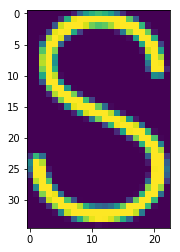

In [42]:
arr = render_letter('TextMeOne-Regular.ttf', 'S')
imshow(arr)

In [43]:
notFound = []
for font in fonts:
    ttf = os.path.join(font_dir, font + '.ttf')
    otf = os.path.join(font_dir, font + '.otf')
    if not os.path.isfile(ttf) and not os.path.isfile(otf):
        notFound.append(font)
        print font

ARSMaquetteWebOne
AnonymousPro
Brevia-Regular
Calluna-Regular
HoeflerText-Regular
YanoneTagesschrift


In [44]:
similarity

{'ARSMaquetteWebOne': 1             CabinCondensed
 2              Telex-Regular
 3               Asap-Regular
 4                GillSansStd
 5    RobotoCondensed-Regular
 Name: 0, dtype: object, 'Acme-Regular': 1          Rosario-Bold
 2      Signika-Semibold
 3    CantoraOne-Regular
 4         Share-BoldOSF
 5    ArialRoundedMTBold
 Name: 1, dtype: object, 'AdventPro-SemiBold': 1                   Voltaire
 2    UbuntuCondensed-Regular
 3          ShareTech-Regular
 4             Rambla-Regular
 5             Strait-Regular
 Name: 2, dtype: object, 'Aldrich': 1    Syncopate-Bold
 2           Trochut
 3         SigmarOne
 4         NovaRound
 5      LeagueGothic
 Name: 3, dtype: object, 'Alegreya-BoldItalic': 1            Lora-BoldItalic
 2     CrimsonText-BoldItalic
 3         PTSerif-BoldItalic
 4    GentiumBasic-BoldItalic
 5              Andada-Italic
 Name: 4, dtype: object, 'AllertaStencil-Regular': 1           Orbitron-Medium
 2    OriginalSurfer-Regular
 3                 Nova

In [45]:
import os

def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [46]:
def render_fonts(font_set, text):
    plt.figure(1)
    _, axarr = plt.subplots(6, len(text))
    row_counter = 0
    for close in font_set:
        col_counter = 0
        for letter in text:
            ttf = os.path.join(font_dir, close + '.ttf')
            otf = os.path.join(font_dir, close + '.otf')
            if os.path.isfile(ttf):
                path = close + '.ttf'
            elif os.path.isfile(otf):
                path = close + '.otf'
            else:
                print "Font not found:", close
                
            arr = render_letter(path, letter)
            axarr[row_counter, col_counter].imshow(arr)
            axarr[row_counter, col_counter].axis('off')
            col_counter += 1
        row_counter += 1

In [57]:
def show_closest(font_index, text):
    closests = find_closest_name(font_index)
    print(closests)
    render_fonts(closests, text)

In [58]:
def show_random(font_index, text):
    rand_range = random.sample(range(len(font)),5)
    closests = [fonts[font_index]] + [fonts[i] for i in rand_range]
    print(closests)
    render_fonts(closests, text)


In [60]:
# 14
test_font_index = 24

0     AveriaSansLibre-Italic
1    AveriaLibre-LightItalic
2                Lato-Italic
3            Overlock-Italic
4               Chivo-Italic
5              Ubuntu-Italic
Name: 24, dtype: object


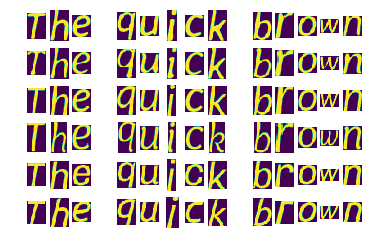

In [61]:
show_closest(test_font_index, 'The quick brown')

['AveriaSansLibre-Italic', 'Arimo-BoldItalic', 'AdventPro-SemiBold', 'Arizonia-Regular', 'AnonymousPro', 'Amethysta-Regular']
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro
Font not found: AnonymousPro


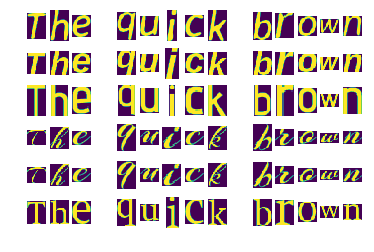

In [62]:
show_random(test_font_index, 'The quick brown')

In [63]:
similarity_df = pd.DataFrame(similarity)

In [64]:
similarity_df.head()

,ARSMaquetteWebOne,Acme-Regular,AdventPro-SemiBold,Aldrich,Alegreya-BoldItalic,AllertaStencil-Regular,Amethysta-Regular,Andada-Bold,Andada-Italic,AndadaSC-Bold,...,Trochut-Italic,Tuffy-BoldItalic,Tulpen,Ubuntu-Italic,UbuntuCondensed-Regular,UbuntuMono-Bold,UbuntuMono-Italic,Voltaire,Wellfleet-Regular,YanoneTagesschrift
1,CabinCondensed,Rosario-Bold,Voltaire,Syncopate-Bold,Lora-BoldItalic,Orbitron-Medium,Enriqueta-Regular,Merriweather-Bold,Rosarivo-Italic,PlayfairDisplay-Black,...,Rosarivo-Italic,Lato-BoldItalic,Jura-Light,Lato-Italic,Voltaire,NanumGothicCoding-Bold,Marvel-BoldItalic,AdventPro-SemiBold,Merriweather-Bold,EagleLake-Regular
2,Telex-Regular,Signika-Semibold,UbuntuCondensed-Regular,Trochut,CrimsonText-BoldItalic,OriginalSurfer-Regular,Merriweather,Arvo-Bold,CrimsonText-BoldItalic,Andada-Bold,...,Andada-Italic,GillSansStd-BoldItalic,BubblerOne,Chivo-Italic,Rambla-Regular,SourceCodePro-Black,Overlock-Italic,UbuntuCondensed-Regular,HeadlandOne-Regular,StardosStencil-Bold
3,Asap-Regular,CantoraOne-Regular,ShareTech-Regular,SigmarOne,PTSerif-BoldItalic,NovaRound,CrimsonText-Semibold,PlayfairDisplay-Black,Arvo-Italic,Arvo-Bold,...,FanwoodText-Italic,Arimo-BoldItalic,Iceland-Regular,Nobile-MediumItalic,RopaSans-Regular,MavenProBlack,Economica-Italic,RopaSans-Regular,Tinos-Bold,KellySlab-Regular
4,GillSansStd,Share-BoldOSF,Rambla-Regular,NovaRound,GentiumBasic-BoldItalic,Kenia-Regular,Calluna-Regular,Tinos-Bold,FanwoodText-Italic,Bevan,...,Cardo-Italic,Lato-BlackItalic,Rationale-Regular,Cabin-SemiBoldItalic,Asap-Regular,Oswald-Bold,Lekton-Italic,ShareTech-Regular,StardosStencil-Bold,Simonetta-Black
5,RobotoCondensed-Regular,ArialRoundedMTBold,Strait-Regular,LeagueGothic,Andada-Italic,MavenProBlack,HoeflerText-Regular,Wellfleet-Regular,Trochut-Italic,SigmarOne,...,PlayfairDisplay-Italic,Cabin-SemiBoldItalic,Megrim,Roboto-MediumItalic,AdventPro-SemiBold,Share-BoldOSF,Ubuntu-Italic,Rambla-Regular,Andada-Bold,ModernAntiqua-Regular


In [ ]:
df.to_csv(file_name, sep='\t')